In [1]:
import numpy as np
import pandas as pd
import os

print('Number of files in the train set: ' + str(len(os.listdir('train'))))
print('Number of files in the test set: ' + str(len(os.listdir('test'))))

Number of files in the train set: 2295
Number of files in the test set: 1531


In [2]:
train_labels = pd.read_csv('train_labels.csv')
train_labels.head()

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


In [3]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head()

,name,invasive
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5


In [4]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm import tqdm

X_train, X_test = [], []

for i in tqdm(train_labels.name):
    img = load_img('train/{}.jpg'.format(i), target_size=(224,224))
    img = img_to_array(img)
    X_train.append(img)

Using TensorFlow backend.
100%|██████████| 2295/2295 [00:59<00:00, 38.55it/s]


In [5]:
X_train[0].shape

(224, 224, 3)

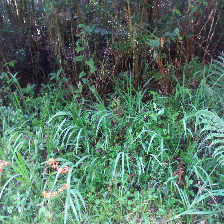

In [6]:
array_to_img(X_train[0])

In [7]:
for i in tqdm(sample_submission.name):
    img = load_img('test/{}.jpg'.format(i), target_size=(224,224))
    img = img_to_array(img)
    X_test.append(img)

100%|██████████| 1531/1531 [00:39<00:00, 39.17it/s]


In [8]:
X_train = np.array(X_train, np.float32) / 255
y_train = np.array(train_labels.invasive)
X_test = np.array(X_test, np.float32) / 255

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(2295, 224, 224, 3)
(2295,)
(1531, 224, 224, 3)


In [10]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

print(X_tr.shape)
print(y_tr.shape)
print(X_te.shape)
print(y_te.shape)

(1836, 224, 224, 3)
(1836,)
(459, 224, 224, 3)
(459,)


In [11]:
y_tr[:10]

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1])

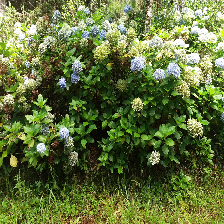

In [12]:
array_to_img(X_tr[2])

In [13]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [14]:
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 32
epochs = 50

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)

train_datagen.fit(X_tr)

callbacks = [EarlyStopping(monitor='val_acc', patience=10, verbose=0),
             ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=0)]

history = model.fit_generator(
    train_datagen.flow(X_tr, y_tr, batch_size=batch_size),
    steps_per_epoch=X_tr.shape[0] // batch_size, epochs=epochs,
    validation_data=(X_te, y_te), callbacks=callbacks)

Epoch 1/50
57/57 [==============================] - 1469s - loss: 0.5172 - acc: 0.7495 - val_loss: 0.3422 - val_acc: 0.8562

In [26]:
y_pred = model.predict(X_test)

In [27]:
sample_submission = pd.read_csv('sample_submission.csv')
name = sample_submission['name']

sub = pd.DataFrame({'name': name, 'invasive': y_pred.ravel()})
sub.to_csv('submission.csv', index=False)

In [28]:
sub.head()

,invasive,name
0,0.999949,1
1,0.001784,2
2,0.011345,3
3,0.000683,4
4,0.999935,5


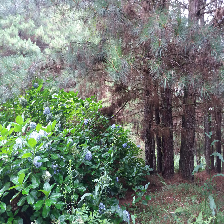

In [33]:
test_img = load_img('test/1.jpg', target_size=(224,224))
test_img

In [34]:
test_img = img_to_array(test_img)
test_img = test_img.reshape((1,) + test_img.shape) / 255
model.predict(test_img)

array([[ 0.9999485]], dtype=float32)

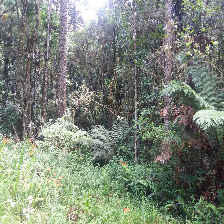

In [37]:
test_img = load_img('test/2.jpg', target_size=(224,224))
test_img

In [38]:
test_img = img_to_array(test_img)
test_img = test_img.reshape((1,) + test_img.shape) / 255
model.predict(test_img)

array([[ 0.00178398]], dtype=float32)

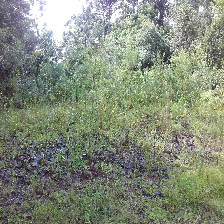

In [39]:
test_img = load_img('test/3.jpg', target_size=(224,224))
test_img

In [40]:
test_img = img_to_array(test_img)
test_img = test_img.reshape((1,) + test_img.shape) / 255
model.predict(test_img)

array([[ 0.0113452]], dtype=float32)

In [1]:
from keras.models import load_model

model_from_file = load_model('model.h5')

Using TensorFlow backend.


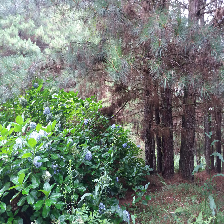

In [2]:
from keras.preprocessing.image import img_to_array, load_img

test_img = load_img('test/1.jpg', target_size=(224,224))
test_img

In [3]:
test_img = img_to_array(test_img)
test_img = test_img.reshape((1,) + test_img.shape) / 255
model_from_file.predict(test_img)

array([[ 0.99946326]], dtype=float32)

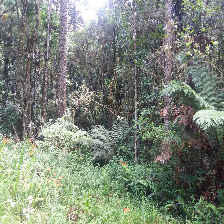

In [4]:
test_img = load_img('test/2.jpg', target_size=(224,224))
test_img

In [5]:
test_img = img_to_array(test_img)
test_img = test_img.reshape((1,) + test_img.shape) / 255
model_from_file.predict(test_img)

array([[ 0.00551927]], dtype=float32)

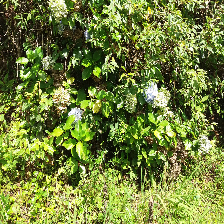

In [6]:
test_img = load_img('test/5.jpg', target_size=(224,224))
test_img

In [7]:
test_img = img_to_array(test_img)
test_img = test_img.reshape((1,) + test_img.shape) / 255
model_from_file.predict(test_img)

array([[ 0.99825555]], dtype=float32)